# Detecting Websites Involved in Phishing
### Dhruv Yadav 2K18/SE/056
### Ishaan Jain 2K18/SE/067
### Kevin Mirchandani 2K18/SE/073

## Imports

In [5]:
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import math
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from math import sqrt
from math import pi
from math import exp
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Loading Data

In [6]:
def generate_data():
    
    df = pd.read_csv(r"phishing.csv")
    X = df.drop(columns = 'class')
    Y = df['class']
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=10, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    X.drop(X.columns.difference(['UsingIP', 'PrefixSuffix-', 'SubDomains', 'HTTPS', 'AnchorURL', 'LinksInScriptTags', 'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex', 'LinksPointingToPage']), 1, inplace=True)
    print()
    print()
    X = np.array(X)
    Y = np.array(Y)
    X_train, X_validation, Y_train,  Y_validation = train_test_split(X, Y, test_size=0.30,stratify=Y,random_state=0)
    
    print("Shape of X_train : ", X_train.shape)
    print()
    print("Shape of X_validation : ", X_validation.shape)
    print()
    print("Shape of Y_train : ", Y_train.shape)
    print()
    print("Shape of Y_validation : ", Y_validation.shape)
    
    return X_train, X_validation, Y_train, Y_validation
    

## KNN From Scratch

In [7]:
#calculating the eucledian distance between two data points

def ucleadian_distance(row, data_point):
    distance = 0.0
    for i in range(len(row)):
        distance = distance + (row[i] - data_point[i]) * (row[i] - data_point[i])
    return math.sqrt(distance)

In [8]:
# choosing the first k closest neighbours
def first_k_neighbours(distances, k):
    
    neighbours = []
    for i in range(k):
        neighbours.append(distances[i][0])
    
    return neighbours

In [9]:
# calculating distance of all neighbours and sorting them in ascending order

def get_neighbours(X_train, Y_train, data_point, k):
    
    distances = []
    for i in range(len(X_train)):
        
        distance = ucleadian_distance(X_train[i],data_point)
        distances.append((Y_train[i],distance))
    
    # sorting the list
    distances.sort(key = lambda x: x[1])
    
    neighbours = first_k_neighbours(distances,k)
    
    return neighbours
    

In [10]:
# calculating the predicted class from k neighbours

def get_prediction(neighbours, k):
    
    class_freq = {}
    for key in neighbours:
        
        if key not in class_freq.keys():
            class_freq[key] = 1
        else:
            class_freq[key] = class_freq[key] + 1
    
    values = list(class_freq.values())
    keys = list(class_freq.keys())

    prediction = keys[values.index(max(values))]
    
    return prediction
        

In [11]:
# predicting class for entire testing dataset

def predict(X_test, X_train, Y_test, Y_train, k):
    
    predictions = []
    
    for data_point in X_test:
        
        neighbours = get_neighbours(X_train, Y_train, data_point, k)
        
        prediction = get_prediction(neighbours, k)
        
        predictions.append(prediction)
        
    return predictions

In [12]:
# returns the accuracy of the model 

def accuracy(predictions, Y_test):
    
    score = 0
    
    for i in range(len(predictions)):
        if predictions[i] == Y_test[i]:
            score = score + 1
    return (score / len(predictions))* 100 

## Splitting Data Into Train, Test Set & Making Predictions

In [13]:
X_train, X_validation, Y_train, Y_validation = generate_data()

Fitting estimator with 31 features.
Fitting estimator with 21 features.
Fitting estimator with 11 features.

10 selected features
['UsingIP', 'PrefixSuffix-', 'SubDomains', 'HTTPS', 'AnchorURL', 'LinksInScriptTags', 'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex', 'LinksPointingToPage']


Shape of X_train :  (7737, 10)

Shape of X_validation :  (3317, 10)

Shape of Y_train :  (7737,)

Shape of Y_validation :  (3317,)


In [14]:
# standardizing the dataset
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)

In [15]:
predictions = predict(X_validation, X_train, Y_validation, Y_train,5)

## Evaluation Metrics

### Accuracy

In [16]:
score = accuracy(predictions, Y_validation)
print("Accuracy obtained on Validation Set by using KNN  model from scratch with k = ",5," : ",score, " %" )

Accuracy obtained on Validation Set by using KNN  model from scratch with k =  5  :  93.57853482062104  %


### Confusion Matrix

In [17]:
matrix = (confusion_matrix(Y_validation,predictions))
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        print(matrix[i][j],end = "     ")
    print()

1369     100     
113     1735     


CONFUSION MATRIX


Text(141.0, 0.5, 'Predicted class value')

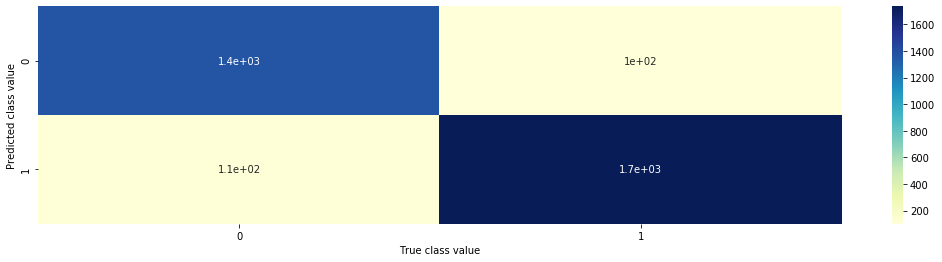

In [18]:
#Print Confusion Matrix

print("CONFUSION MATRIX")
plt.figure(figsize=(18,4))
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(matrix, annot=True, cmap="YlGnBu")
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.xlabel('True class value')
plt.ylabel('Predicted class value')

### Classification Report

In [19]:
 print(classification_report(Y_validation, predictions))

              precision    recall  f1-score   support

          -1       0.92      0.93      0.93      1469
           1       0.95      0.94      0.94      1848

    accuracy                           0.94      3317
   macro avg       0.93      0.94      0.93      3317
weighted avg       0.94      0.94      0.94      3317



## Inbuilt KNN Classifier

In [ ]:
neighbors = list(range(1,20))

scores = []

for k in neighbors:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    score = knn.score(X_validation, Y_validation)*100
    scores.append(score)

MSE = np.array([1 - x for x in scores])

neighbors = np.array(neighbors)
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, Y_train)
score = neigh.score(X_validation, Y_validation)*100
print("Accuracy obtained on Validation Set by using the inbuilt KNN model with k = ",5," : ",score, " %" )

##   Naive Bayes Classifier From Scratch

In [20]:
#Separate by class


# Split the dataset by class values, returns a dictionary
def separate_by_class(X,Y):
    separated = {}
    for i in range(len(X)):
        key = Y[i]
        value = X[i]
        if key in separated.keys():
            separated[key].append(value)
        else:
            separated[key] = [value]
    
    return separated
    

In [21]:
# Calculate the mean of a list of numbers
def mean(numbers):
    return sum(numbers)/float(len(numbers))

In [22]:
# Calculate the standard deviation of a list of numbers
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)
from math import sqrt


In [23]:
#Summarize the dataset
# Calculate the mean, stdev and count for each column in a dataset
def summarize_dataset(X):
    summaries = [(mean(column), stdev(column), len(column)) for column in zip(*X)]
    return summaries

In [24]:

# Split dataset by class then calculate statistics for each row
def summarize_by_class(X,Y):
    separated = separate_by_class(X,Y)
    summaries = dict()
    for class_value, rows in separated.items():
        summaries[class_value] = summarize_dataset(rows)
    return summaries

In [25]:

# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent

In [26]:
# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
    total_rows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
       
        for i in range(len(class_summaries)):
            mean, stdev, count = class_summaries[i]
            
            probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
    return probabilities

In [27]:
def predictNB(X):
    
    summary = summarize_by_class(X_train,Y_train)
    summary[-1][1] = (-1.0,0.8,3248)
    
    predictions = []
    for i in range(len(X)):
        prediction = calculate_class_probabilities(summary,X[i])
        class_value = 0
        if prediction[1] >= prediction[-1]:
            class_value = 1
        else:
            class_value = -1
        predictions.append(class_value)
    
    return predictions

## Splitting Data Into Train, Test Set & Making Predictions

In [28]:
X_train, X_validation, Y_train, Y_validation = generate_data()

Fitting estimator with 31 features.
Fitting estimator with 21 features.
Fitting estimator with 11 features.

10 selected features
['UsingIP', 'PrefixSuffix-', 'SubDomains', 'HTTPS', 'AnchorURL', 'LinksInScriptTags', 'ServerFormHandler', 'WebsiteTraffic', 'GoogleIndex', 'LinksPointingToPage']


Shape of X_train :  (7737, 10)

Shape of X_validation :  (3317, 10)

Shape of Y_train :  (7737,)

Shape of Y_validation :  (3317,)


In [29]:
predictions = predictNB(X_validation)

## Evaluation Metrics

### Accuracy

In [30]:
score = accuracy(predictions, Y_validation)
print("Accuracy obtained on Validation Set by using the inbuilt Naive Bayes classifier : ",score, " %" )

Accuracy obtained on Validation Set by using the inbuilt Naive Bayes classifier :  91.49834187518843  %


### Confusion Matrix

In [31]:
matrix = (confusion_matrix(Y_validation,predictions))
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        print(matrix[i][j],end = "     ")
    print()

1319     150     
132     1716     


CONFUSION MATRIX


Text(141.0, 0.5, 'Predicted class value')

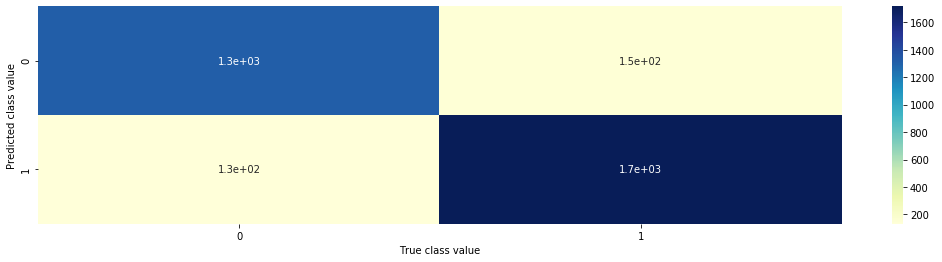

In [32]:
#Print Confusion Matrix

print("CONFUSION MATRIX")
plt.figure(figsize=(18,4))
uniform_data = np.random.rand(10, 12)
ax = sns.heatmap(matrix, annot=True, cmap="YlGnBu")
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.xlabel('True class value')
plt.ylabel('Predicted class value')

### Classification Report

In [33]:
 print(classification_report(Y_validation, predictions))

              precision    recall  f1-score   support

          -1       0.91      0.90      0.90      1469
           1       0.92      0.93      0.92      1848

    accuracy                           0.91      3317
   macro avg       0.91      0.91      0.91      3317
weighted avg       0.91      0.91      0.91      3317



#### END OF ASSIGNMENT